In [2]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
from torchvision import datasets
from torchvision.transforms import transforms

from random import randint
import numpy as np
import matplotlib.pyplot as plt


'''
Step 1: Prepare dataset
'''
# Use data with only 4 and 9 as labels: which is hardest to classify
label_1, label_2 = 4, 9

# MNIST training data
train_set = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

# Use data with two labels
idx = (train_set.targets == label_1) + (train_set.targets == label_2)
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets == label_1] = -1
train_set.targets[train_set.targets == label_2] = 1

# MNIST testing data
test_set = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Use data with two labels
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets == label_1] = -1
test_set.targets[test_set.targets == label_2] = 1

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/Users/ernestryu/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
'''
Step 2: Define the neural network class
'''
class LR(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # MNIST data is 28x28 images
    def __init__(self, input_dim=28*28) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)

    ''' forward given input x '''
    def forward(self, x) :
        return self.linear(x.float().view(-1, 28*28))
    
# class MLP4(nn.Module) :
#     '''
#     Initialize model
#         input_dim : dimension of given input data
#     '''
#     # CIFAR-10 data is 32*32 images with 3 RGB channels
#     def __init__(self, input_dim=28*28) :
#         super().__init__()
#         self.linear = nn.Linear(input_dim, input_dim//2, bias=True)
#         self.linear2 = nn.Linear(input_dim//2, input_dim//4, bias=True)
#         self.linear3 = nn.Linear(input_dim//4, input_dim//8, bias=True)
#         self.linear4 = nn.Linear(input_dim//8, 1, bias=True)
        
#     ''' forward given input x '''
#     def forward(self, x) :
#         x = x.float().view(-1, 28*28)
#         x = nn.functional.relu(self.linear(x))
#         x = nn.functional.relu(self.linear2(x))
#         x = nn.functional.relu(self.linear3(x))
#         x = self.linear4(x)
#         return x

In [10]:
'''
Step 3: Create the model, specify loss function and optimizer.
'''
model = LR()                                   # Define a Neural Network Model

def logistic_loss(output, target):
    return -torch.nn.functional.logsigmoid(target*output)

loss_function = logistic_loss                                                   # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)   # specify SGD with learning rate

In [11]:
'''
Step 4: Train model with SGD
'''
for _ in range(1000) :
    # Sample a random data for training
    ind = randint(0, len(train_set.data)-1)
    image, label = train_set.data[ind], train_set.targets[ind]

    # Clear previously computed gradient
    optimizer.zero_grad()

    # then compute gradient with forward and backward passes
    train_loss = loss_function(model(image), label.float())
    train_loss.backward()

    #(This syntax will make more sense once we learn about minibatches)

    # perform SGD step (parameter update)
    optimizer.step()

In [12]:
'''
Step 5: Test model (Evaluate the accuracy)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

# Evaluate accuracy using test data
for ind in range(len(test_set.data)) :

    image, label = test_set.data[ind], test_set.targets[ind]

    # evaluate model
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label.float()).item()

    # Make a prediction
    if output.item() * label.item() >= 0 :
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_set.data), correct, len(test_set.data),
        100. * correct / len(test_set.data)))

[Test set] Average loss: 0.1351, Accuracy: 1892/1991 (95.03%)



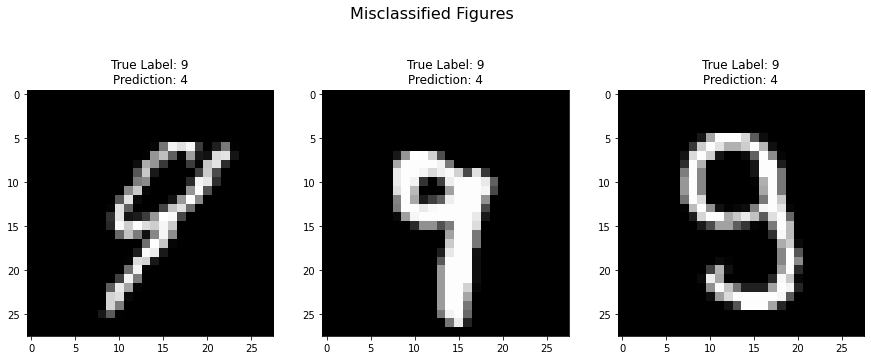

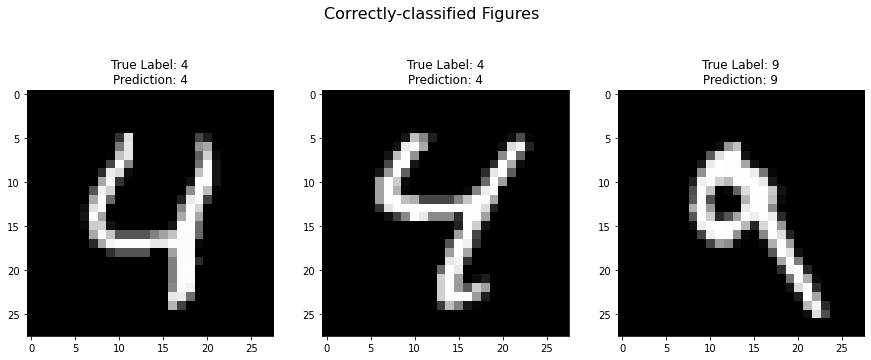

In [13]:
'''
Step 6: Show some incorrectly classified images and some correctly classified ones
''' 
# Misclassified images
fig = plt.figure(1, figsize=(15, 6))
fig.suptitle('Misclassified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[misclassified_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_2))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_1))
    plt.imshow(image, cmap='gray')
plt.show()

# Correctly classified images
fig = plt.figure(2, figsize=(15, 6))
fig.suptitle('Correctly-classified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[correct_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[correct_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_1))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_2))
    plt.imshow(image, cmap='gray')
plt.show()